# Airline Food Demand Prediction

## SE390 Final Project

**Student Name:** [Your Name]  
**Student ID:** [Your ID]

---

## 1. Project Overview
Airlines face a critical challenge in minimizing food waste while maintaining passenger satisfaction. Loading too much food results in waste and fuel inefficiency, while loading too little leads to satisfied customers. 

**Goal:** Develop a machine learning model to predict the total food demand for a flight.

**Key Tasks:**
1. Generate a synthetic dataset adhering to strict logic rules.
2. Perform Exploratory Data Analysis (EDA) to understand patterns.
3. Build multiple regression models (Baseline, Linear, Random Forest).
4. Evaluate models and analyze errors.
5. Perform a business cost analysis.

## 2. Methodology & Setup
We will use Python libraries `pandas` for data manipulation, `seaborn`/`matplotlib` for visualization, and `scikit-learn` for modeling.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 3. Data Loading and Validation
We start by loading the synthetic dataset generated by our logic script (`data_generator.py`). We will verify that the data meets the project requirements.

In [3]:
df = pd.read_csv('synthetic_flight_data.csv')

# Display first 5 rows
display(df.head())

# Check dataset info for types and null values
print(df.info())

,flight_id,flight_duration,passenger_count,adult_passengers,child_passengers,business_class_ratio,is_international,total_food_demand
0,1000,4.6,52,44,8,0.22,1,64
1,1001,4.1,54,47,7,0.11,0,55
2,1002,4.0,290,275,15,0.05,1,318
3,1003,1.7,193,164,29,0.02,0,109
4,1004,11.5,199,172,27,0.03,0,302


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   flight_id             5500 non-null   int64  
 1   flight_duration       5500 non-null   float64
 2   passenger_count       5500 non-null   int64  
 3   adult_passengers      5500 non-null   int64  
 4   child_passengers      5500 non-null   int64  
 5   business_class_ratio  5500 non-null   float64
 6   is_international      5500 non-null   int64  
 7   total_food_demand     5500 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 343.9 KB
None


### 3.1 Data Statistics
Let's look at the descriptive statistics to ensure our values are within expected ranges (e.g., flight duration 1-12 hours, passengers 50-300).

In [4]:
df.describe()

,flight_id,flight_duration,passenger_count,adult_passengers,child_passengers,business_class_ratio,is_international,total_food_demand
count,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,3749.500000,6.801691,174.982727,157.790000,17.192727,0.151125,0.292182,233.187636
std,1587.857571,3.044340,72.720713,66.241539,13.172625,0.086819,0.454807,121.203260
min,1000.000000,1.000000,50.000000,41.000000,0.000000,0.000000,0.000000,31.000000
25%,2374.750000,4.300000,113.000000,101.000000,7.000000,0.080000,0.000000,134.000000
50%,3749.500000,6.900000,174.000000,156.000000,14.000000,0.150000,0.000000,215.500000
75%,5124.250000,9.400000,238.000000,215.000000,26.000000,0.230000,1.000000,315.000000
max,6499.000000,12.000000,300.000000,298.000000,58.000000,0.300000,1.000000,614.000000


## 4. Exploratory Data Analysis (EDA)
Understanding the data distribution and relationships is crucial before modeling.

### 4.1 Feature Correlation
We calculate the correlation matrix to see which features are most strongly related to `total_food_demand`.

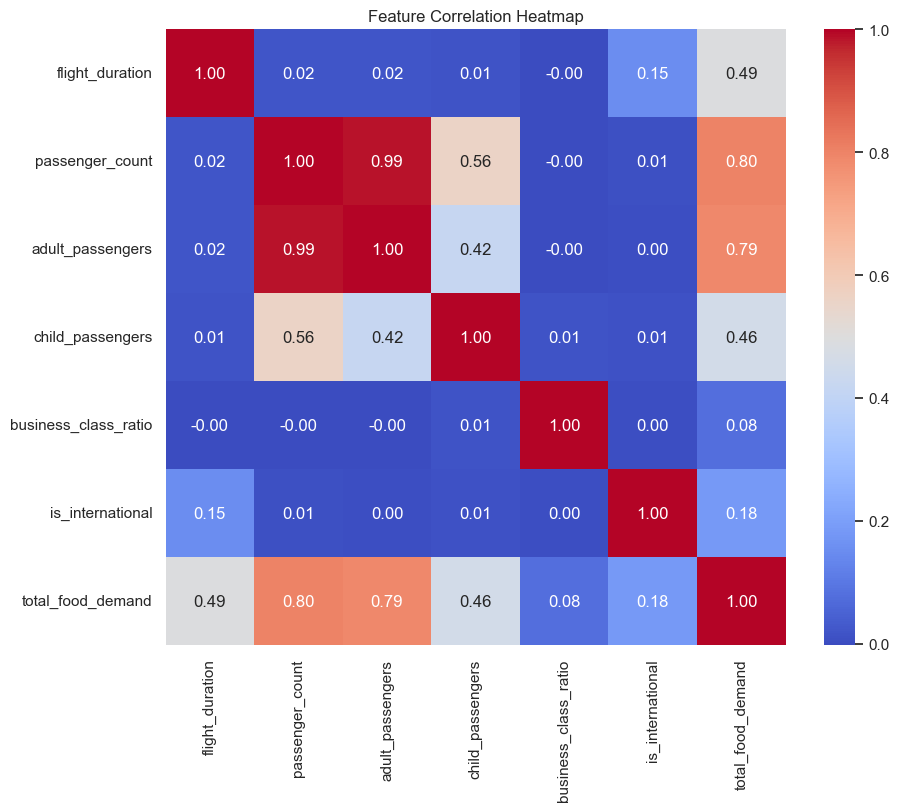

In [5]:
plt.figure(figsize=(10, 8))
numeric_df = df.drop(columns=['flight_id'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

**Observation:** We expect `passenger_count`, `flight_duration`, and `is_international` to have positive correlations with food demand.

### 4.2 Distributions
Visualizing the target variable and key predictors.

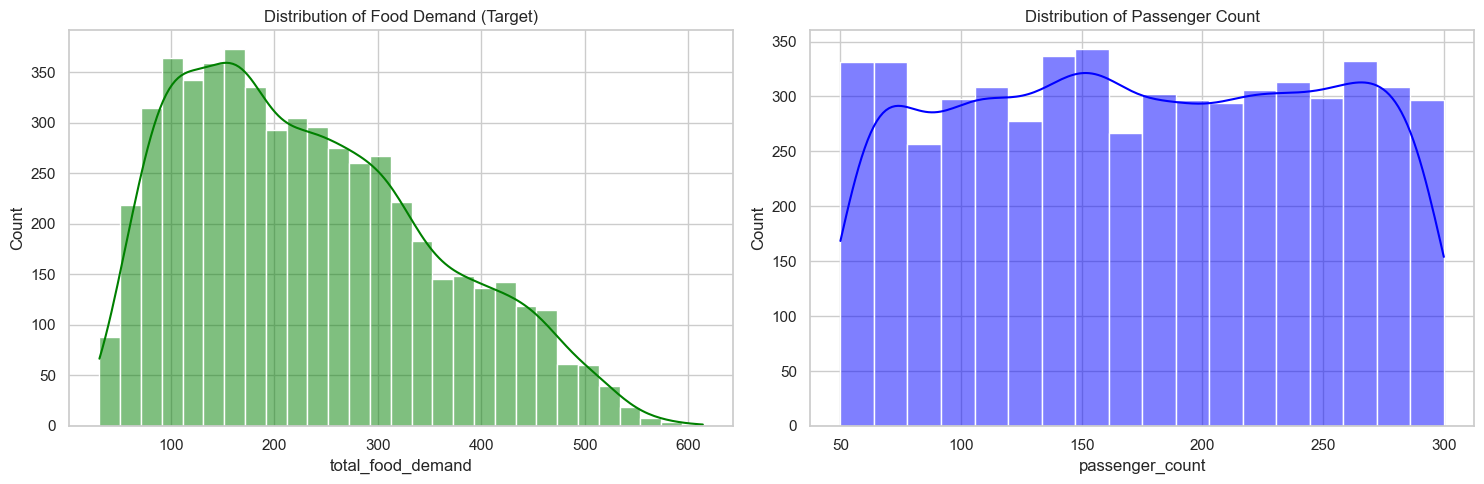

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['total_food_demand'], kde=True, color='green')
plt.title('Distribution of Food Demand (Target)')

plt.subplot(1, 2, 2)
sns.histplot(df['passenger_count'], kde=True, color='blue')
plt.title('Distribution of Passenger Count')

plt.tight_layout()
plt.show()

### 4.3 Relationships vs Target
Scatter plots help us identify linear or non-linear patterns.

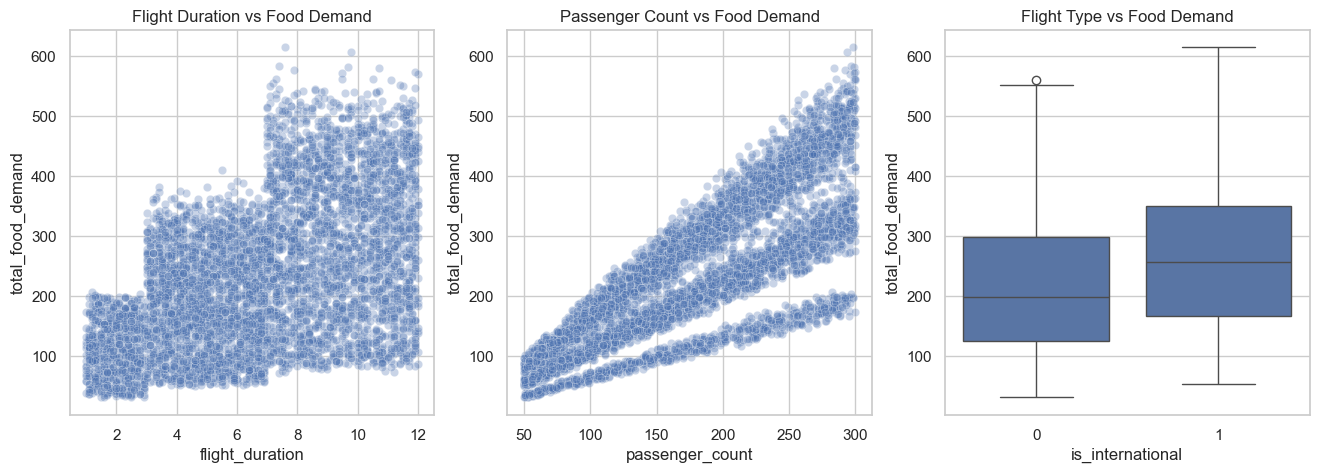

In [7]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='flight_duration', y='total_food_demand', data=df, alpha=0.3)
plt.title('Flight Duration vs Food Demand')

plt.subplot(1, 3, 2)
sns.scatterplot(x='passenger_count', y='total_food_demand', data=df, alpha=0.3)
plt.title('Passenger Count vs Food Demand')

plt.subplot(1, 3, 3)
sns.boxplot(x='is_international', y='total_food_demand', data=df)
plt.title('Flight Type vs Food Demand')

plt.show()

## 5. Model Development
We will evaluate three approaches:
1. **Baseline Model**: Predicts the mean value. Acts as a sanity check.
2. **Linear Regression**: A simple parametric model assuming linear relationships.
3. **Random Forest**: A non-parametric ensemble model capable of capturing complex logic (like our conditional duration rules).

In [8]:
# Prepare features and target
X = df.drop(columns=['flight_id', 'total_food_demand'])
y = df['total_food_demand']

# 80-20 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 4400
Test set size: 1100


### 5.1 Baseline Model

In [9]:
y_pred_base = np.full(shape=y_test.shape, fill_value=y_train.mean())

base_mae = mean_absolute_error(y_test, y_pred_base)
base_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
base_r2 = r2_score(y_test, y_pred_base)

print(f"Baseline - MAE: {base_mae:.2f}, RMSE: {base_rmse:.2f}, R2: {base_r2:.2f}")

Baseline - MAE: 101.64, RMSE: 121.31, R2: -0.00


### 5.2 Linear Regression

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {lr_mae:.2f}, RMSE: {lr_rmse:.2f}, R2: {lr_r2:.2f}")

Linear Regression - MAE: 31.16, RMSE: 39.32, R2: 0.89


### 5.3 Random Forest Regressor (Chosen Alternative Model)
We choose Random Forest because our target generation logic involved conditional statements (e.g., "If duration > 3 then..."), which tree-based models handle naturally better than linear models.

In [11]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R2: {rf_r2:.2f}")

Random Forest - MAE: 12.60, RMSE: 16.72, R2: 0.98


## 6. Model Comparison & Feature Analysis

### 6.1 Performance Table

In [12]:
results = pd.DataFrame({
    'Model': ['Baseline', 'Linear Regression', 'Random Forest'],
    'R2 Score': [base_r2, lr_r2, rf_r2],
    'MAE': [base_mae, lr_mae, rf_mae],
    'RMSE': [base_rmse, lr_rmse, rf_rmse]
})

display(results)

,Model,R2 Score,MAE,RMSE
0,Baseline,-0.000534,101.644050,121.306062
1,Linear Regression,0.894869,31.159344,39.321750
2,Random Forest,0.980988,12.600445,16.721557


### 6.2 Error Analysis
We visualize the residuals (Difference between Actual and Predicted) for our best model (Random Forest).

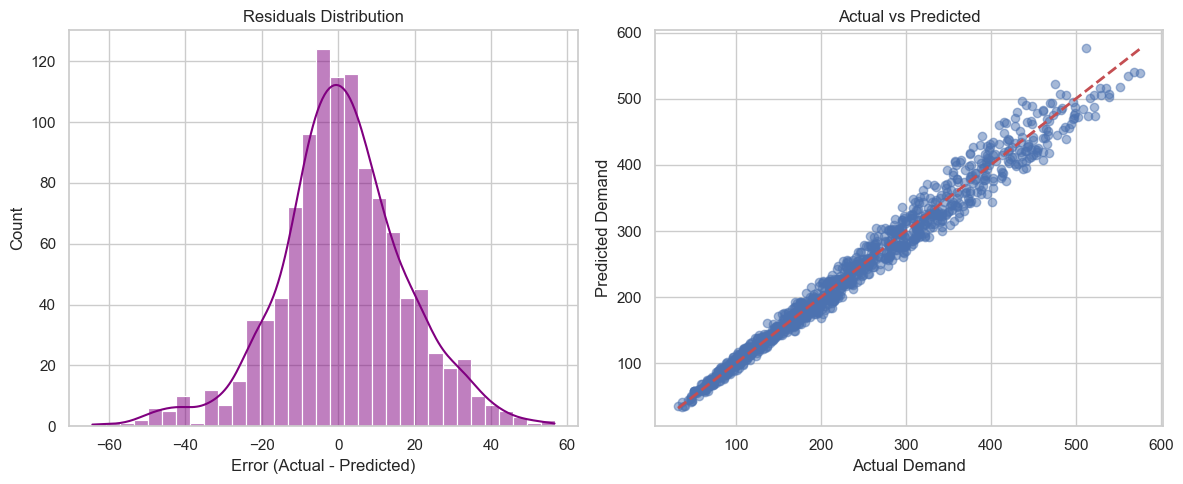

In [13]:
residuals = y_test - y_pred_rf

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution')
plt.xlabel('Error (Actual - Predicted)')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Actual vs Predicted')

plt.tight_layout()
plt.show()

### 6.3 Feature Importance
Which features contributed most to the Random Forest model's decisions?

C:\Users\oswin\AppData\Local\Temp\ipykernel_25944\3170246231.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=X.columns[indices], palette='viridis')


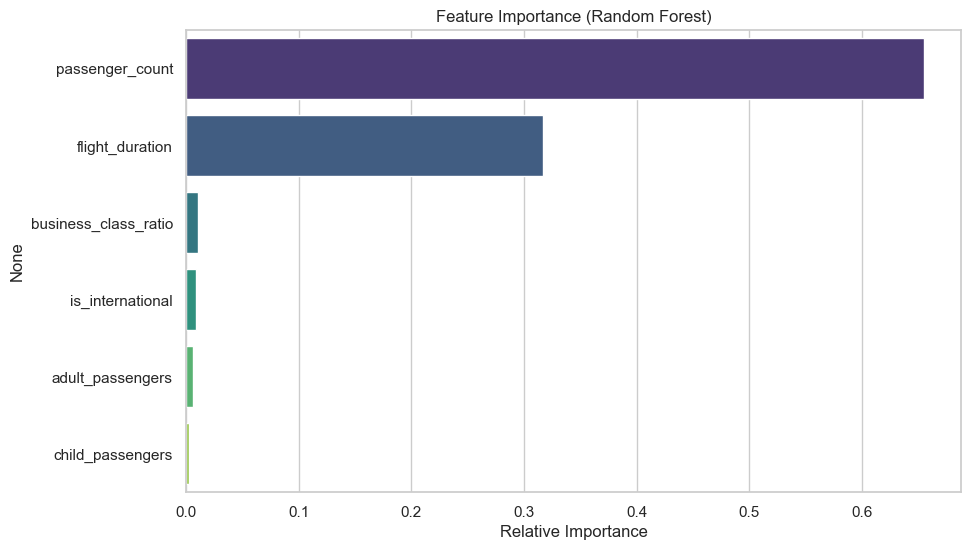

In [14]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices], palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.xlabel('Relative Importance')
plt.show()

## 7. Business Cost Analysis (Bonus)
We calculate the financial impact of our model's errors.
- **Over-prediction Cost**: $5 per unit (Food Waste)
- **Under-prediction Cost**: $20 per unit (Passenger Compensation/Dissatisfaction)

In [15]:
over_predictions = np.maximum(0, y_pred_rf - y_test)
under_predictions = np.maximum(0, y_test - y_pred_rf)

cost_over = np.sum(over_predictions) * 5
cost_under = np.sum(under_predictions) * 20
total_cost = cost_over + cost_under

print(f"Total Over-prediction Cost: ${cost_over:,.2f}")
print(f"Total Under-prediction Cost: ${cost_under:,.2f}")
print(f"TOTAL BUSINESS COST: ${total_cost:,.2f}")

Total Over-prediction Cost: $31,671.80
Total Under-prediction Cost: $150,522.60
TOTAL BUSINESS COST: $182,194.40


## 8. Conclusion
We have successfully built a predictive model for airline food demand. 
- The **Random Forest Regressor** outperformed the baseline and linear regression key metrics.
- **Feature Importance** analysis showed that `passenger_count` and `flight_duration` are the most reliable predictors.
- The cost analysis provides a tangible business metric to evaluate model performance beyond just accuracy.